## TabNet

## Setting

In [ ]:
!pip install pytorch_tabnet
!pip install optuna

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import torch
import torch.nn as nn
import scipy

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
def seed_everything(seed = 21):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [5]:
def read_split_data():
    df = pd.read_csv('/content/drive/MyDrive/Data/adult.csv')
    X = {}
    y = {}
    X['train'], X['test'], y['train'], y['test'] = train_test_split(df.iloc[:, :-1], df.income, test_size = 0.10, random_state=21)
    X['train'], X['val'], y['train'], y['val'] = train_test_split(X['train'], y['train'], test_size = 0.10, random_state=21)

    return X, y

In [30]:
def preprocessing(X, y):
    cat_index = X['train'].select_dtypes(['object']).columns
    num_index = X['train'].select_dtypes(['int64']).columns

    # categorical cardinalities / categorical index for TabNet
    cat_cardinalities = []

    column_order = {col: idx for idx, col in enumerate(X['train'].columns)}
    cat_column_index = [column_order[col] for col in cat_index]

    # StandardScaler
    ss = StandardScaler()
    X['train'][num_index] = ss.fit_transform(X['train'][num_index])
    X['val'][num_index] = ss.transform(X['val'][num_index])
    X['test'][num_index] = ss.transform(X['test'][num_index])

    # LabelEncoder
    for col in cat_index:
      le = LabelEncoder()

      X['train'][col] = le.fit_transform(X['train'][col])

      # X_val, X_test에만 존재하는 label이 있을 경우
      for label in np.unique(X['val'][col]):
        if label not in le.classes_:
          le.classes_ = np.append(le.classes_, label)

      for label in np.unique(X['test'][col]):
        if label not in le.classes_:
          le.classes_ = np.append(le.classes_, label)

      X['val'][col] = le.transform(X['val'][col])
      X['test'][col] = le.transform(X['test'][col])

      # cardinalities
      max_cat = np.max([np.max(X['train'][col]),
                        np.max(X['val'][col]),
                        np.max(X['test'][col])]) + 1
      cat_cardinalities.append(max_cat)

    # y = 1 if > 50K
    y['train'] = np.where(y['train']=='>50K', 1.0, 0.0)
    y['val'] = np.where(y['val']=='>50K', 1.0, 0.0)
    y['test'] = np.where(y['test']=='>50K', 1.0, 0.0)

    return X, y, cat_cardinalities, cat_column_index

## Run

In [80]:
X, y = read_split_data()
X, y, cat_cardinalities, cat_column_index = preprocessing(X, y)

X['train'] = X['train'].values
X['val'] = X['val'].values
X['test'] = X['test'].values

# This illustrates the behaviour of the model's fit method using Compressed Sparse Row matrices
sparse_X_train = scipy.sparse.csr_matrix(X['train'])  # Create a CSR matrix from X_train
sparse_X_valid = scipy.sparse.csr_matrix(X['val'])  # Create a CSR matrix from X_valid

In [82]:
tabnet_params = {"cat_idxs": cat_column_index,
                 "cat_dims": cat_cardinalities,
                 "cat_emb_dim": 2,
                 "optimizer_fn": torch.optim.Adam,
                 "optimizer_params": dict(lr=1e-3),
                 "scheduler_fn": None,
                 "mask_type": 'sparsemax',
                 "device_name": 'cuda',
                 "n_d": 8,
                 "n_a": 8,
                 "n_steps": 3,
                 "gamma": 1.3,
                 "seed": 21}

clf = TabNetClassifier(**tabnet_params)

max_epochs = 15

# Fitting the model
clf.fit(X_train=sparse_X_train, y_train=y['train'],
        eval_set=[(sparse_X_train, y['train']), (sparse_X_valid, y['val'])],
        eval_name=['train', 'val'],
        eval_metric=['accuracy', 'logloss'],
        max_epochs=max_epochs,
        patience=10,
        batch_size=1024,
        virtual_batch_size=128,)

epoch 0  | loss: 0.8903  | train_accuracy: 0.70415 | train_logloss: 0.62085 | val_accuracy: 0.70905 | val_logloss: 0.61757 |  0:00:15s
epoch 1  | loss: 0.61087 | train_accuracy: 0.77622 | train_logloss: 0.5204  | val_accuracy: 0.77866 | val_logloss: 0.516   |  0:00:30s
epoch 2  | loss: 0.51547 | train_accuracy: 0.79025 | train_logloss: 0.47296 | val_accuracy: 0.79504 | val_logloss: 0.46864 |  0:00:41s
epoch 3  | loss: 0.47067 | train_accuracy: 0.79912 | train_logloss: 0.44668 | val_accuracy: 0.79891 | val_logloss: 0.44878 |  0:00:51s
epoch 4  | loss: 0.44522 | train_accuracy: 0.80574 | train_logloss: 0.42845 | val_accuracy: 0.80983 | val_logloss: 0.433   |  0:01:01s
epoch 5  | loss: 0.43168 | train_accuracy: 0.80986 | train_logloss: 0.41552 | val_accuracy: 0.81119 | val_logloss: 0.41996 |  0:01:11s
epoch 6  | loss: 0.4164  | train_accuracy: 0.81338 | train_logloss: 0.402   | val_accuracy: 0.8146  | val_logloss: 0.40528 |  0:01:24s
epoch 7  | loss: 0.40668 | train_accuracy: 0.81783 | tr

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


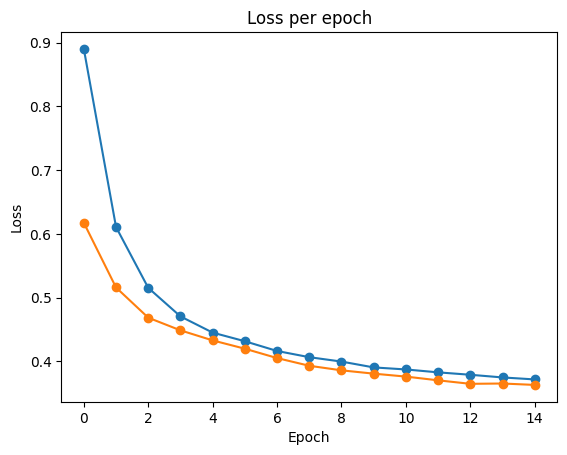

In [85]:
# plot losses
plt.plot(clf.history['loss'], marker='o', label='train')
plt.plot(clf.history['val_logloss'], marker='o', label='val')
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

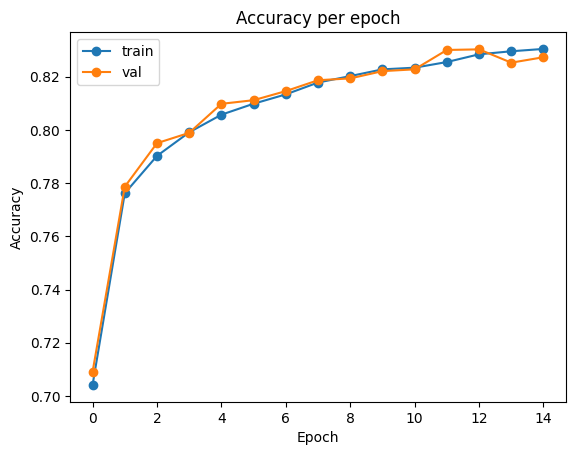

In [86]:
# plot accuracy
plt.plot(clf.history['train_accuracy'], label='train', marker='o')
plt.plot(clf.history['val_accuracy'], label='val', marker='o')
plt.title('Accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [88]:
preds = clf.predict(X['test'])
test_acc = accuracy_score(y_pred=preds, y_true=y['test'])

print('Test acc:', test_acc)

Test acc: 0.8286591606960082


## Tuning

In [99]:
# optuna objective
def objective(trial):
    n_d_a = trial.suggest_int('n_d_a', 8, 64)
    n_steps = trial.suggest_int('n_steps', 3, 10)
    gamma = trial.suggest_float('gamma', 1.0, 2.0)
    lr = trial.suggest_float('lr', 1e-5, 1e-2)
    cat_emb_dim = trial.suggest_int('cat_emb_dim', 1, 4)

    tabnet_params = {"cat_idxs": cat_column_index,
                     "cat_dims": cat_cardinalities,
                     "cat_emb_dim": 2,
                     "optimizer_fn": torch.optim.Adam,
                     "optimizer_params": dict(lr=lr),
                     "scheduler_fn": None,
                     "mask_type": 'sparsemax',
                     "device_name": 'cuda',
                     "n_d": n_d_a,
                     "n_a": n_d_a,
                     "n_steps": n_steps,
                     "gamma": gamma,
                     "verbose": 0,
                     "seed": 21}

    clf = TabNetClassifier(**tabnet_params)

    max_epochs = 10

    # Fitting the model
    clf.fit(X_train=sparse_X_train, y_train=y['train'],
            eval_set=[(sparse_X_train, y['train']), (sparse_X_valid, y['val'])],
            eval_name=['train', 'val'],
            eval_metric=['accuracy', 'logloss'],
            max_epochs=max_epochs,
            batch_size=1024,
            virtual_batch_size=128,)

    # return minimun loss
    return clf.best_cost

In [100]:
study = optuna.create_study(study_name='TabNet', direction='minimize', sampler=TPESampler(seed=21))
study.optimize(lambda trial: objective(trial), n_trials=15)

print()
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

[I 2023-09-05 12:09:02,260] A new study created in memory with name: TabNet


Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_logloss = 0.49775


[I 2023-09-05 12:11:04,528] Trial 0 finished with value: 0.497748676354725 and parameters: {'n_d_a': 10, 'n_steps': 5, 'gamma': 1.7209663468312297, 'lr': 0.00022594633666033845, 'cat_emb_dim': 1}. Best is trial 0 with value: 0.497748676354725.


Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_logloss = 0.36955


[I 2023-09-05 12:13:05,825] Trial 1 finished with value: 0.3695493117804688 and parameters: {'n_d_a': 10, 'n_steps': 5, 'gamma': 1.6639102946247, 'lr': 0.00308806278843642, 'cat_emb_dim': 3}. Best is trial 1 with value: 0.3695493117804688.


Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_logloss = 0.36649


[I 2023-09-05 12:15:29,125] Trial 2 finished with value: 0.36648749477170106 and parameters: {'n_d_a': 11, 'n_steps': 9, 'gamma': 1.1332405192517476, 'lr': 0.0017894653689793888, 'cat_emb_dim': 2}. Best is trial 2 with value: 0.36648749477170106.


Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_logloss = 0.36146


[I 2023-09-05 12:17:52,964] Trial 3 finished with value: 0.36145532329285557 and parameters: {'n_d_a': 57, 'n_steps': 9, 'gamma': 1.9704851253491578, 'lr': 0.0075954325023276726, 'cat_emb_dim': 2}. Best is trial 3 with value: 0.36145532329285557.


Stop training because you reached max_epochs = 10 with best_epoch = 7 and best_val_logloss = 0.34688


[I 2023-09-05 12:20:09,326] Trial 4 finished with value: 0.34687673212281495 and parameters: {'n_d_a': 31, 'n_steps': 8, 'gamma': 1.2706697726731337, 'lr': 0.008542487691193527, 'cat_emb_dim': 4}. Best is trial 4 with value: 0.34687673212281495.


Stop training because you reached max_epochs = 10 with best_epoch = 7 and best_val_logloss = 0.34067


[I 2023-09-05 12:22:17,860] Trial 5 finished with value: 0.3406719760543788 and parameters: {'n_d_a': 51, 'n_steps': 7, 'gamma': 1.1678357652215072, 'lr': 0.002993935993172568, 'cat_emb_dim': 2}. Best is trial 5 with value: 0.3406719760543788.


Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_logloss = 0.36398


[I 2023-09-05 12:24:21,314] Trial 6 finished with value: 0.3639811568004794 and parameters: {'n_d_a': 26, 'n_steps': 6, 'gamma': 1.5443683594576376, 'lr': 0.0021818346888996224, 'cat_emb_dim': 4}. Best is trial 5 with value: 0.3406719760543788.


Stop training because you reached max_epochs = 10 with best_epoch = 7 and best_val_logloss = 0.3537


[I 2023-09-05 12:26:49,135] Trial 7 finished with value: 0.35370463597422713 and parameters: {'n_d_a': 49, 'n_steps': 9, 'gamma': 1.2675218045820724, 'lr': 0.006152098864372861, 'cat_emb_dim': 3}. Best is trial 5 with value: 0.3406719760543788.


Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_logloss = 0.36213


[I 2023-09-05 12:28:53,942] Trial 8 finished with value: 0.3621329834177557 and parameters: {'n_d_a': 30, 'n_steps': 6, 'gamma': 1.8101575494926372, 'lr': 0.006007688961167527, 'cat_emb_dim': 4}. Best is trial 5 with value: 0.3406719760543788.


Stop training because you reached max_epochs = 10 with best_epoch = 6 and best_val_logloss = 0.36416


[I 2023-09-05 12:31:18,719] Trial 9 finished with value: 0.36416007058714683 and parameters: {'n_d_a': 35, 'n_steps': 9, 'gamma': 1.8588894711682389, 'lr': 0.00788656698497452, 'cat_emb_dim': 4}. Best is trial 5 with value: 0.3406719760543788.


Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_logloss = 0.32297


[I 2023-09-05 12:33:05,599] Trial 10 finished with value: 0.32296540432319226 and parameters: {'n_d_a': 47, 'n_steps': 3, 'gamma': 1.1169525121171846, 'lr': 0.004003327754543372, 'cat_emb_dim': 1}. Best is trial 10 with value: 0.32296540432319226.


Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_logloss = 0.32734


[I 2023-09-05 12:34:53,511] Trial 11 finished with value: 0.32733886584840094 and parameters: {'n_d_a': 47, 'n_steps': 3, 'gamma': 1.0221741264181599, 'lr': 0.004399067563874516, 'cat_emb_dim': 1}. Best is trial 10 with value: 0.32296540432319226.


Stop training because you reached max_epochs = 10 with best_epoch = 8 and best_val_logloss = 0.33514


[I 2023-09-05 12:36:43,127] Trial 12 finished with value: 0.3351395237441098 and parameters: {'n_d_a': 45, 'n_steps': 3, 'gamma': 1.0135898404859338, 'lr': 0.004625214953709157, 'cat_emb_dim': 1}. Best is trial 10 with value: 0.32296540432319226.


Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_logloss = 0.32768


[I 2023-09-05 12:38:36,589] Trial 13 finished with value: 0.3276812458162435 and parameters: {'n_d_a': 64, 'n_steps': 3, 'gamma': 1.0347330464390387, 'lr': 0.004387414907740412, 'cat_emb_dim': 1}. Best is trial 10 with value: 0.32296540432319226.


Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_val_logloss = 0.33016


[I 2023-09-05 12:40:40,320] Trial 14 finished with value: 0.33015582241187647 and parameters: {'n_d_a': 42, 'n_steps': 4, 'gamma': 1.3157904843973294, 'lr': 0.005515244660750329, 'cat_emb_dim': 1}. Best is trial 10 with value: 0.32296540432319226.



Best Score: 0.32296540432319226
Best trial: {'n_d_a': 47, 'n_steps': 3, 'gamma': 1.1169525121171846, 'lr': 0.004003327754543372, 'cat_emb_dim': 1}


In [101]:
optuna.visualization.plot_optimization_history(study)

In [102]:
optuna.visualization.plot_param_importances(study)

In [103]:
study.best_trial.params

{'n_d_a': 47,
 'n_steps': 3,
 'gamma': 1.1169525121171846,
 'lr': 0.004003327754543372,
 'cat_emb_dim': 1}

In [104]:
tabnet_params = {"cat_idxs": cat_column_index,
                 "cat_dims": cat_cardinalities,
                 "cat_emb_dim": study.best_trial.params['cat_emb_dim'],
                 "optimizer_fn": torch.optim.Adam,
                 "optimizer_params": dict(lr=study.best_trial.params['lr']),
                 "scheduler_fn": None,
                 "mask_type": 'sparsemax',
                 "device_name": 'cuda',
                 "n_d": study.best_trial.params['n_d_a'],
                 "n_a": study.best_trial.params['n_d_a'],
                 "n_steps": study.best_trial.params['n_steps'],
                 "gamma": study.best_trial.params['gamma'],
                 "seed": 21}

clf = TabNetClassifier(**tabnet_params)

max_epochs = 15

# Fitting the model
clf.fit(X_train=sparse_X_train, y_train=y['train'],
        eval_set=[(sparse_X_train, y['train']), (sparse_X_valid, y['val'])],
        eval_name=['train', 'val'],
        eval_metric=['accuracy', 'logloss'],
        max_epochs=max_epochs,
        patience=10,
        batch_size=1024,
        virtual_batch_size=128,)

epoch 0  | loss: 0.49173 | train_accuracy: 0.77389 | train_logloss: 0.47868 | val_accuracy: 0.77047 | val_logloss: 0.49163 |  0:00:10s
epoch 1  | loss: 0.39038 | train_accuracy: 0.82703 | train_logloss: 0.38494 | val_accuracy: 0.83076 | val_logloss: 0.39008 |  0:00:21s
epoch 2  | loss: 0.3699  | train_accuracy: 0.83623 | train_logloss: 0.36424 | val_accuracy: 0.83348 | val_logloss: 0.37667 |  0:00:32s
epoch 3  | loss: 0.35702 | train_accuracy: 0.84047 | train_logloss: 0.35016 | val_accuracy: 0.84008 | val_logloss: 0.36179 |  0:00:42s
epoch 4  | loss: 0.35281 | train_accuracy: 0.84513 | train_logloss: 0.34084 | val_accuracy: 0.84122 | val_logloss: 0.35128 |  0:00:53s
epoch 5  | loss: 0.34478 | train_accuracy: 0.84533 | train_logloss: 0.33774 | val_accuracy: 0.84167 | val_logloss: 0.35046 |  0:01:04s
epoch 6  | loss: 0.34343 | train_accuracy: 0.84834 | train_logloss: 0.33089 | val_accuracy: 0.84031 | val_logloss: 0.34412 |  0:01:14s
epoch 7  | loss: 0.3344  | train_accuracy: 0.84927 | tr

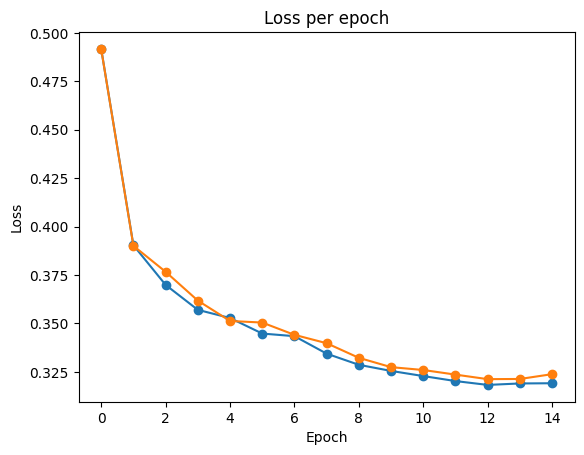

In [105]:
# plot losses
plt.plot(clf.history['loss'], marker='o', label='train')
plt.plot(clf.history['val_logloss'], marker='o', label='val')
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

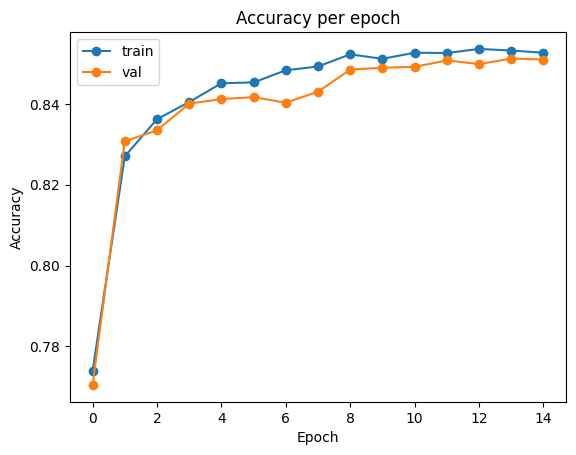

In [106]:
# plot accuracy
plt.plot(clf.history['train_accuracy'], label='train', marker='o')
plt.plot(clf.history['val_accuracy'], label='val', marker='o')
plt.title('Accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [107]:
preds = clf.predict(X['test'])
test_acc = accuracy_score(y_pred=preds, y_true=y['test'])

print('Test acc:', test_acc)

Test acc: 0.8503582395087002


## Pre-training

In [110]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(cat_idxs=cat_column_index,
                                      cat_dims=cat_cardinalities,
                                      cat_emb_dim=1,
                                      optimizer_fn=torch.optim.Adam,
                                      optimizer_params=dict(lr=1e-3),
                                      mask_type='sparsemax',
                                      n_shared_decoder=1,
                                      n_indep_decoder=1,
                                      verbose=5,)

unsupervised_model.fit(X_train=X['train'],
                       eval_set=[X['val']],
                       max_epochs=50 ,
                       patience=5,
                       batch_size=2048,
                       virtual_batch_size=128,
                       num_workers=0,
                       drop_last=False,
                       pretraining_ratio=0.5,)

epoch 0  | loss: 18.36013| val_0_unsup_loss_numpy: 7.435939788818359|  0:00:01s
epoch 5  | loss: 2.99452 | val_0_unsup_loss_numpy: 1.9117200374603271|  0:00:10s
epoch 10 | loss: 1.26313 | val_0_unsup_loss_numpy: 1.2095400094985962|  0:00:19s
epoch 15 | loss: 1.0563  | val_0_unsup_loss_numpy: 1.0479300022125244|  0:00:28s
epoch 20 | loss: 1.00818 | val_0_unsup_loss_numpy: 0.999180018901825|  0:00:36s
epoch 25 | loss: 0.99364 | val_0_unsup_loss_numpy: 0.9830700159072876|  0:00:46s
epoch 30 | loss: 0.99167 | val_0_unsup_loss_numpy: 0.9723100066184998|  0:00:55s
epoch 35 | loss: 0.97055 | val_0_unsup_loss_numpy: 0.9566299915313721|  0:01:04s
epoch 40 | loss: 0.97176 | val_0_unsup_loss_numpy: 0.9371100068092346|  0:01:14s
epoch 45 | loss: 0.97622 | val_0_unsup_loss_numpy: 0.9140400290489197|  0:01:23s
Stop training because you reached max_epochs = 50 with best_epoch = 49 and best_val_0_unsup_loss_numpy = 0.8928999900817871


In [111]:
clf = TabNetClassifier(**tabnet_params)

max_epochs = 15

# Fitting the model
clf.fit(X_train=sparse_X_train, y_train=y['train'],
        eval_set=[(sparse_X_train, y['train']), (sparse_X_valid, y['val'])],
        eval_name=['train', 'val'],
        eval_metric=['accuracy', 'logloss'],
        max_epochs=max_epochs,
        patience=10,
        batch_size=1024,
        virtual_batch_size=128,
        from_unsupervised=unsupervised_model)

epoch 0  | loss: 0.52595 | train_accuracy: 0.7996  | train_logloss: 0.44058 | val_accuracy: 0.79254 | val_logloss: 0.45424 |  0:00:11s
epoch 1  | loss: 0.39799 | train_accuracy: 0.81381 | train_logloss: 0.38998 | val_accuracy: 0.81324 | val_logloss: 0.3999  |  0:00:22s
epoch 2  | loss: 0.38019 | train_accuracy: 0.82409 | train_logloss: 0.36878 | val_accuracy: 0.81733 | val_logloss: 0.37811 |  0:00:32s
epoch 3  | loss: 0.37182 | train_accuracy: 0.82736 | train_logloss: 0.36359 | val_accuracy: 0.81938 | val_logloss: 0.3768  |  0:00:43s
epoch 4  | loss: 0.3656  | train_accuracy: 0.83031 | train_logloss: 0.3561  | val_accuracy: 0.82257 | val_logloss: 0.36368 |  0:00:54s
epoch 5  | loss: 0.35767 | train_accuracy: 0.83592 | train_logloss: 0.35132 | val_accuracy: 0.82552 | val_logloss: 0.36114 |  0:01:06s
epoch 6  | loss: 0.3543  | train_accuracy: 0.84063 | train_logloss: 0.34489 | val_accuracy: 0.83121 | val_logloss: 0.35658 |  0:01:17s
epoch 7  | loss: 0.35046 | train_accuracy: 0.84154 | tr

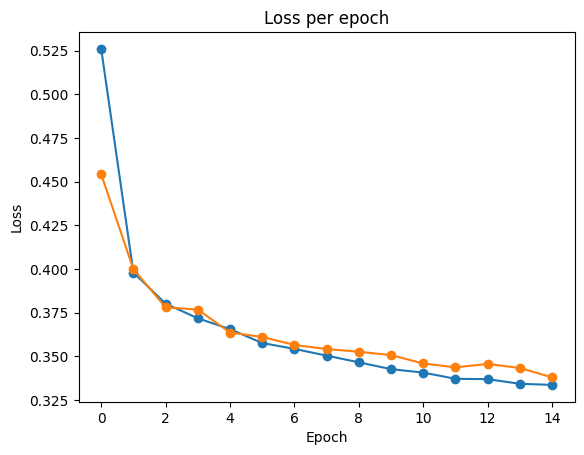

In [112]:
# plot losses
plt.plot(clf.history['loss'], marker='o', label='train')
plt.plot(clf.history['val_logloss'], marker='o', label='val')
plt.title('Loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

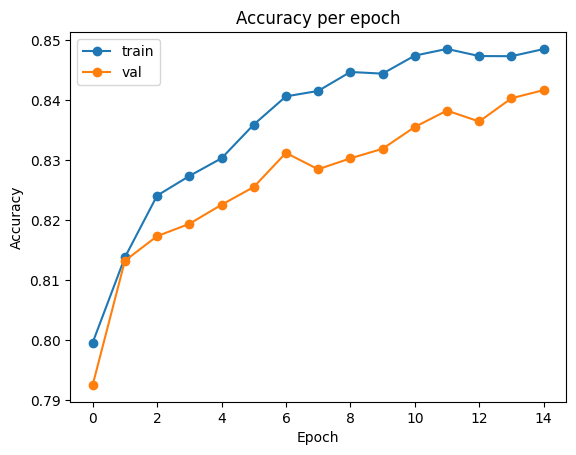

In [113]:
# plot accuracy
plt.plot(clf.history['train_accuracy'], label='train', marker='o')
plt.plot(clf.history['val_accuracy'], label='val', marker='o')
plt.title('Accuracy per epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [114]:
preds = clf.predict(X['test'])
test_acc = accuracy_score(y_pred=preds, y_true=y['test'])

print('Test acc:', test_acc)

Test acc: 0.84503582395087
